# Loading and Preprocessing Data

### Images

In [7]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [8]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

The dataset that we will use is a Flower dataset containing 5 sub-directories, one per class:
1. daisy/
2. dandelion/
3. roses/
4. sunflowers/
5. tulips/

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


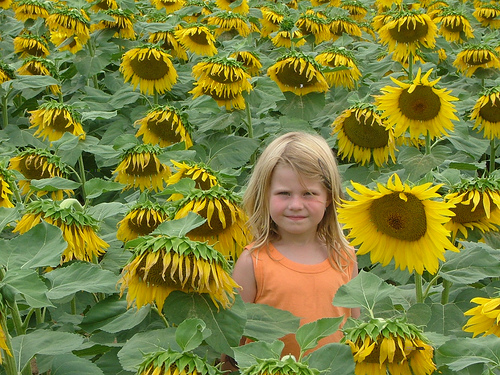

In [11]:
dandelion = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(dandelion[5]))

### Create a dataset

In [21]:
batch_size = 32
img_height = 180
img_width = 180

In [22]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [23]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [24]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualization

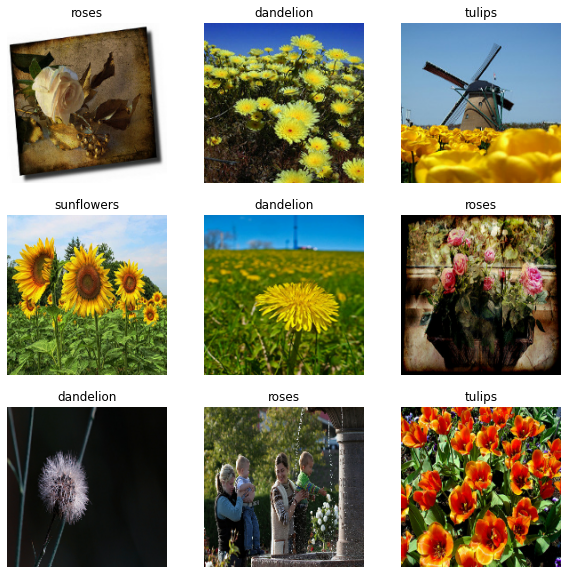

In [25]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Standardize/Normalize the data to between [0, 1] using the Rescalling layer.

In [27]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Training the model

In [30]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [31]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 303s 3s/step - loss: 1.3262 - accuracy: 0.4278 - val_loss: 1.1320 - val_accuracy: 0.5368
Epoch 2/3
92/92 [==============================] - 275s 3s/step - loss: 1.0296 - accuracy: 0.5957 - val_loss: 1.0050 - val_accuracy: 0.6063
Epoch 3/3
92/92 [==============================] - 281s 3s/step - loss: 0.8535 - accuracy: 0.6805 - val_loss: 0.9217 - val_accuracy: 0.6362


The validation accuracy is low compared to the training accuracy, indication that the model is overfitting.

## Text

In [31]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
  text_dir = tf.keras.utils.get_file(name, origin=DIRECTORY_URL+name)
  
parent_dir = os.path.dirname(text_dir)

parent_dir

'/home/troye/.keras/datasets'

### Loading text into datasets

In [32]:
def labeler(example, index):
  return example, tf.cast(index, tf.int64)  

labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(os.path.join(parent_dir, file_name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

In [33]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
TAKE_SIZE = 5000

In [34]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
  
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [35]:
for ex in all_labeled_data.take(5):
  print(ex)



(<tf.Tensor: shape=(), dtype=string, numpy=b'Where were the respite then from ceaseless fast?'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b"Undaunted, but are arm'd with smaller shields,">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'pacing round the bier with piteous groaning and lamentation.'>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Die therefore, even thou, my friend! What mean'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'hands. Let the heralds summon the people to gather at their several'>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)


### Builing Vocabulary

In [36]:
tokenizer = tfds.deprecated.text.Tokenizer()

vocabulary_set = set()
for text_tensor, _ in all_labeled_data:
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size

17178

Create an encoder by passing vocablary_set 

In [37]:
encoder = tfds.deprecated.text.TokenTextEncoder(vocabulary_set)

In [39]:
ex_text = next(iter(all_labeled_data))[0].numpy()
print(ex_text)

b'Where were the respite then from ceaseless fast?'


In [40]:
encoded_example = encoder.encode(ex_text)
print(encoded_example)

[14366, 321, 6742, 7644, 16157, 1245, 13571, 10015]


Run the encoder on the dataset by wrapping it.

In [41]:
def encode(text_tensor, label):
    encoded_text = encoder.encode(text_tensor.numpy())
    return encoded_text, label

In [45]:
def encode_map_fn(text, label):
  encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int64))
  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label


all_encoded_data = all_labeled_data.map(encode_map_fn)

### Split the dataset into test and train batches

In [46]:
train_data = all_encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE)

test_data = all_encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE)

In [56]:
sample_text, sample_labels = next(iter(test_data))

sample_text[0], sample_labels[0]

(<tf.Tensor: shape=(13,), dtype=int64, numpy=
 array([14366,   321,  6742,  7644, 16157,  1245, 13571, 10015,     0,
            0,     0,     0,     0])>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

In [57]:
vocab_size += 1

#### Building the model

In [58]:
model = tf.keras.Sequential()

In [59]:
model.add(tf.keras.layers.Embedding(vocab_size, 64))

In [60]:
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))

In [61]:
for units in [64, 64]:
    model.add(tf.keras.layers.Dense(units, activation='relu'))
model.add(tf.keras.layers.Dense(3))

In [62]:
model.compile(optimizer='adam', loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

## Training

In [63]:
model.fit(train_data, epochs=3, validation_data=test_data)



Epoch 1/3
697/697 [==============================] - 59s 84ms/step - loss: 0.5226 - accuracy: 0.7514 - val_loss: 0.3938 - val_accuracy: 0.8206
Epoch 2/3
697/697 [==============================] - 57s 82ms/step - loss: 0.3006 - accuracy: 0.8691 - val_loss: 0.3665 - val_accuracy: 0.8298
Epoch 3/3
697/697 [==============================] - 61s 88ms/step - loss: 0.2304 - accuracy: 0.9000 - val_loss: 0.4187 - val_accuracy: 0.8206


In [64]:
eval_loss, eval_acc = model.evaluate(test_data)

print('\nEval loss: {:.3f}, Eval accuracy: {:.3f}'.format(eval_loss, eval_acc))



79/79 [==============================] - 5s 61ms/step - loss: 0.4187 - accuracy: 0.8206

Eval loss: 0.419, Eval accuracy: 0.821


From this, we can deduce that the model runs on a 82% accuracy.